In [20]:
import pandas as pd
from datetime import datetime
import numpy as np
import tarfile
import community
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [21]:
tar_file_path = 'data/period_data.tar'
combined_df = pd.DataFrame()

# Open the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    # Iterate through each member in the tar file
    for member in tar.getmembers():
        # Check if the file is a .parquet file
        if member.isfile() and member.name.endswith('.parquet'):
            # Extract the file
            extracted_file = tar.extractfile(member)
            if extracted_file:
                # Load the parquet file into a DataFrame
                daily_df = pd.read_parquet(extracted_file)
                # Reset the index and keep it as a column
                daily_df.reset_index(inplace=True)
                # Append to the combined DataFrame
                combined_df = pd.concat([combined_df, daily_df], ignore_index=True)

combined_df


,xltime,bid_price,bid_volume,ask_price,ask_volume,price,stock
0,2012-03-01 09:30:00-05:00,40.934394,178,41.132879,525,41.082622,CORN
1,2012-03-01 09:31:00-05:00,40.972564,72,41.120000,150,41.072183,CORN
2,2012-03-01 09:32:00-05:00,40.995385,25,41.117692,157,41.100892,CORN
3,2012-03-01 09:33:00-05:00,41.008200,100,41.107200,362,41.085771,CORN
4,2012-03-01 09:35:00-05:00,40.974000,25,41.108000,175,41.091250,CORN
...,...,...,...,...,...,...,...
4033941,2012-12-31 15:55:00-05:00,47.417671,55952,47.428298,120881,47.424936,XLY
4033942,2012-12-31 15:56:00-05:00,47.386378,161080,47.396953,227951,47.392575,XLY
4033943,2012-12-31 15:57:00-05:00,47.352095,55767,47.363543,131497,47.360134,XLY
4033944,2012-12-31 15:58:00-05:00,47.370508,67879,47.381836,147840,47.378272,XLY


In [22]:
filtered_df = combined_df.copy()
filtered_df = filtered_df.pivot_table(index='xltime', columns='stock', values='price', aggfunc='mean')
filtered_df.index = pd.to_datetime(filtered_df.index)

# Calculate log-returns for each stock
log_returns = filtered_df.copy()
log_returns.iloc[:, :] = log_returns.apply(lambda col: np.log(col).diff())

log_returns['Date'] = log_returns.index.date
daily_data = log_returns.groupby('Date').apply(lambda x: x.drop(columns='Date').values.flatten())
daily_data_df = pd.DataFrame(daily_data.tolist(), index=daily_data.index)
daily_data_df = daily_data_df.fillna(0)
daily_data_df


/var/folders/z3/q3dm3kvj43q24611cgswtyph0000gp/T/ipykernel_25287/3628737183.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_data = log_returns.groupby('Date').apply(lambda x: x.drop(columns='Date').values.flatten())


,0,1,2,3,4,5,6,7,8,9,...,21495,21496,21497,21498,21499,21500,21501,21502,21503,21504
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001466,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-05,0.003376,-0.008051,-0.003954,0.025658,0.016990,-0.001213,-0.000982,-0.004444,-0.003477,-0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-06,0.000000,-0.026283,-0.017232,0.000000,-0.035591,-0.015456,-0.010891,-0.029496,-0.018443,-0.048076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-07,0.004224,-0.002617,-0.001126,0.104389,0.052562,0.006222,0.002311,-0.001737,-0.000459,0.007913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
correlation_matrix = daily_data_df.T.corr()
correlation_matrix

Date,2012-03-01,2012-03-02,2012-03-05,2012-03-06,2012-03-07,2012-03-08,2012-03-09,2012-03-12,2012-03-13,2012-03-14,...,2012-12-17,2012-12-18,2012-12-19,2012-12-20,2012-12-21,2012-12-24,2012-12-26,2012-12-27,2012-12-28,2012-12-31
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-01,1.000000,0.006607,0.010345,0.003982,0.008404,0.003989,-0.005370,0.001777,-0.003710,-0.003217,...,0.029060,0.010862,-0.002260,-0.030561,0.012051,0.003023,0.000493,0.000842,-0.002203,0.001760
2012-03-02,0.006607,1.000000,-0.108782,0.012157,0.010208,0.005094,0.101886,0.004793,-0.005186,0.008259,...,0.005575,-0.007979,0.002677,-0.010256,0.033852,0.001972,-0.009774,-0.002423,0.002810,-0.013245
2012-03-05,0.010345,-0.108782,1.000000,0.317709,0.268091,-0.134155,0.142286,0.133727,-0.004329,0.273908,...,0.114731,0.048168,0.040513,-0.009547,0.074606,-0.001341,-0.015812,-0.002889,-0.030490,-0.008561
2012-03-06,0.003982,0.012157,0.317709,1.000000,-0.113111,-0.373592,0.282343,0.031993,-0.004411,0.236142,...,0.077590,0.201883,-0.143949,-0.015937,0.417521,0.000165,-0.004014,0.005479,0.248977,-0.051913
2012-03-07,0.008404,0.010208,0.268091,-0.113111,1.000000,0.069978,0.005866,0.136925,-0.008523,0.161216,...,0.024505,-0.076924,0.174563,-0.013297,-0.120561,0.000766,-0.020583,-0.003034,-0.162856,0.045187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,0.003023,0.001972,-0.001341,0.000165,0.000766,-0.002696,0.001413,0.000884,-0.002131,0.002934,...,0.002985,-0.002610,-0.000275,-0.004977,-0.001192,1.000000,-0.001619,0.002547,-0.001065,0.007232
2012-12-26,0.000493,-0.009774,-0.015812,-0.004014,-0.020583,-0.002586,-0.005127,-0.004141,0.010271,0.016202,...,0.021845,0.005031,-0.026149,0.008549,-0.003910,-0.001619,1.000000,0.009289,0.017032,0.003001
2012-12-27,0.000842,-0.002423,-0.002889,0.005479,-0.003034,0.001419,0.000854,-0.000708,0.009953,0.003100,...,-0.013823,-0.013797,0.000340,0.013029,-0.012533,0.002547,0.009289,1.000000,0.001256,0.014447


In [24]:
import networkx as nx

G = nx.Graph()

# Add nodes
for day in correlation_matrix.index:
    G.add_node(day)

# Add edges with weights based on correlation
for i, row in correlation_matrix.iterrows():
    for j, value in row.items():  # Use `.items()` instead of `.iteritems()`
        if i != j and value > 0:  # Only consider positive correlations
            G.add_edge(i, j, weight=value)

# Apply Louvain clustering
partition = community.community_louvain.best_partition(G, weight='weight')

# Convert results to a DataFrame
clusters = pd.DataFrame({'Day': list(partition.keys()), 'Cluster': list(partition.values())})
len(clusters.groupby('Cluster'))


4

/var/folders/z3/q3dm3kvj43q24611cgswtyph0000gp/T/ipykernel_25287/1841700985.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


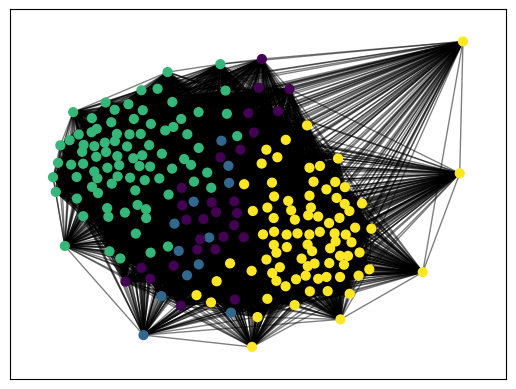

In [25]:
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()